** pip install sk-video **

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

height, width = 64, 64

# Display Image
import PIL.Image
from cStringIO import StringIO
import IPython.display
import numpy as np
def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    
def display_images(output_image):
    fig = plt.figure(figsize=(height, width))  # width, height in inches
    for i in range(32):
        sub = fig.add_subplot(8, 8, i + 1)
        sub.imshow(output_image[i], interpolation='nearest')

In [ ]:
import skvideo.io
import skvideo.datasets
videodata = skvideo.io.vread("../../UCF101/v_Archery_g05_c01.avi")

In [ ]:
print (videodata.shape)

In [ ]:
import cv2
frames = []
for each_frame in videodata:
    resized_image = cv2.resize(each_frame, (64,64))
    frames.append(resized_image)
frames = np.array(frames)

In [ ]:
frames.shape

In [ ]:
display_images(frames)

In [ ]:
# save video
skvideo.io.vwrite('vid.mp4', frames)

In [ ]:
# TensorFlow Model !
import tensorflow as tf

# Run when your in trouble ... !
tf.reset_default_graph()

batch_size = 128
timesteps = 32
shape = [64, 64]
kernel = [3, 3]
channels = 3
filters = 12

In [ ]:
# Create a placeholder for videos.
inputs = tf.placeholder(tf.float32, [batch_size, timesteps] + shape + [channels]) # (batch_size, timestep, H, W, C)
outputs_exp = tf.placeholder(tf.float32, [batch_size, timesteps] + shape + [channels] ) # (batch_size, timestep, H, W, C)

In [ ]:
# Add the ConvLSTM step.
from cell import ConvLSTMCell
cell = ConvLSTMCell(shape, filters, kernel)
outputs, state = tf.nn.dynamic_rnn(cell, inputs, dtype=inputs.dtype)

In [ ]:
print(inputs)
print (outputs_exp)
print(outputs)
print (state)

** ADD intial_state in dynamic_rnn below ..., remove dtype **

** Name scopping **

    with tf.variable_scope('lstm1'):
          output, state = tf.nn.rnn_cell.BasicLSTMCell(3)(input, init_state)
    with tf.variable_scope('lstm2'):
          output2, state2 = tf.nn.rnn_cell.BasicLSTMCell(3)(input2, init_state2)

** DroupOut ... is there anywhere place to add **

** Does output requires W, b multiplication again ... ??? **

In [ ]:
filters = [32,128,32,3]
cells = []
# Multi Layer LSTM
# Iterate over each layer ... 
for i, each_filter in enumerate(filters):
    cell = ConvLSTMCell(shape, each_filter, kernel)
    cells.append(cell)
    
cell = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=True)
states_series, current_state = tf.nn.dynamic_rnn(cell,inputs,dtype=tf.float32)

In [ ]:
print (states_series)
print (current_state)

In [ ]:
# L2 Loss
frames_difference = tf.subtract(states_series,outputs_exp)
batch_l2_loss = tf.nn.l2_loss(frames_difference)
# divide by batch size ... 
l2_loss = tf.divide(batch_l2_loss, float(batch_size))

# Optimizer 
train_step = tf.train.AdamOptimizer().minimize(l2_loss)

In [ ]:
print (l2_loss)

In [ ]:
# Video pickling try
import os
import numpy as np
import cv2
import skvideo.io
import pickle
import time
start_time = time.time()

DIR = "../../data/"
data = {}
c = 0 
for path, subdirs, files in os.walk(DIR):
    for filename in files:
        f = os.path.join(path, filename)
        video_data = skvideo.io.vread(f)
        resized_frames = []
        for each_frame in video_data:
            resized_frames.append(cv2.resize(each_frame, (64,64)))
        resized_frames = np.array(resized_frames)
        # print (resized_frames.shape)
        data[f] = resized_frames
        c += 1
        if c%10==0:
            print ("Processing ", c) 
        # break
        
print ("Total ",c)

with open('../../data_map.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("--- %s seconds ---" % (time.time() - start_time))
# with open('filename.pickle', 'rb') as handle:
#    b = pickle.load(handle)

In [ ]:
import numpy as np
x = np.arange(10*455*64*64*3)
np.save("../../np_array_save",x)

In [ ]:
# test saving videos when multiple videos given in the same np array
videodata1 = skvideo.io.vread("../../UCF101/v_Archery_g05_c01.avi")
videodata2 = skvideo.io.vread("../../UCF101/v_Archery_g10_c01.avi")

all_frames = []
frames1, frames2 = [], []
for each_frame1, each_frame2 in zip(videodata1, videodata2):
    resized_image1 = cv2.resize(each_frame1, (64,64))
    resized_image2 = cv2.resize(each_frame2, (64,64))    
    frames = [resized_image1, resized_image2]
    all_frames.append(frames)
all_frames = np.array(all_frames)

In [ ]:
# get number of videos and no of frames in each video
no_videos = all_frames.shape[1]
no_frames = all_frames.shape[0]

In [ ]:
no_frames, no_videos

In [ ]:
# save each video given in the np array
count = 0
for i in range(no_videos):
    cur_video = np.array([all_frames[j][i] for j in range(no_frames)])
    skvideo.io.vwrite(str(count) + '.mp4', cur_video)
    count += 1

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from datasets import frame_extraction as f

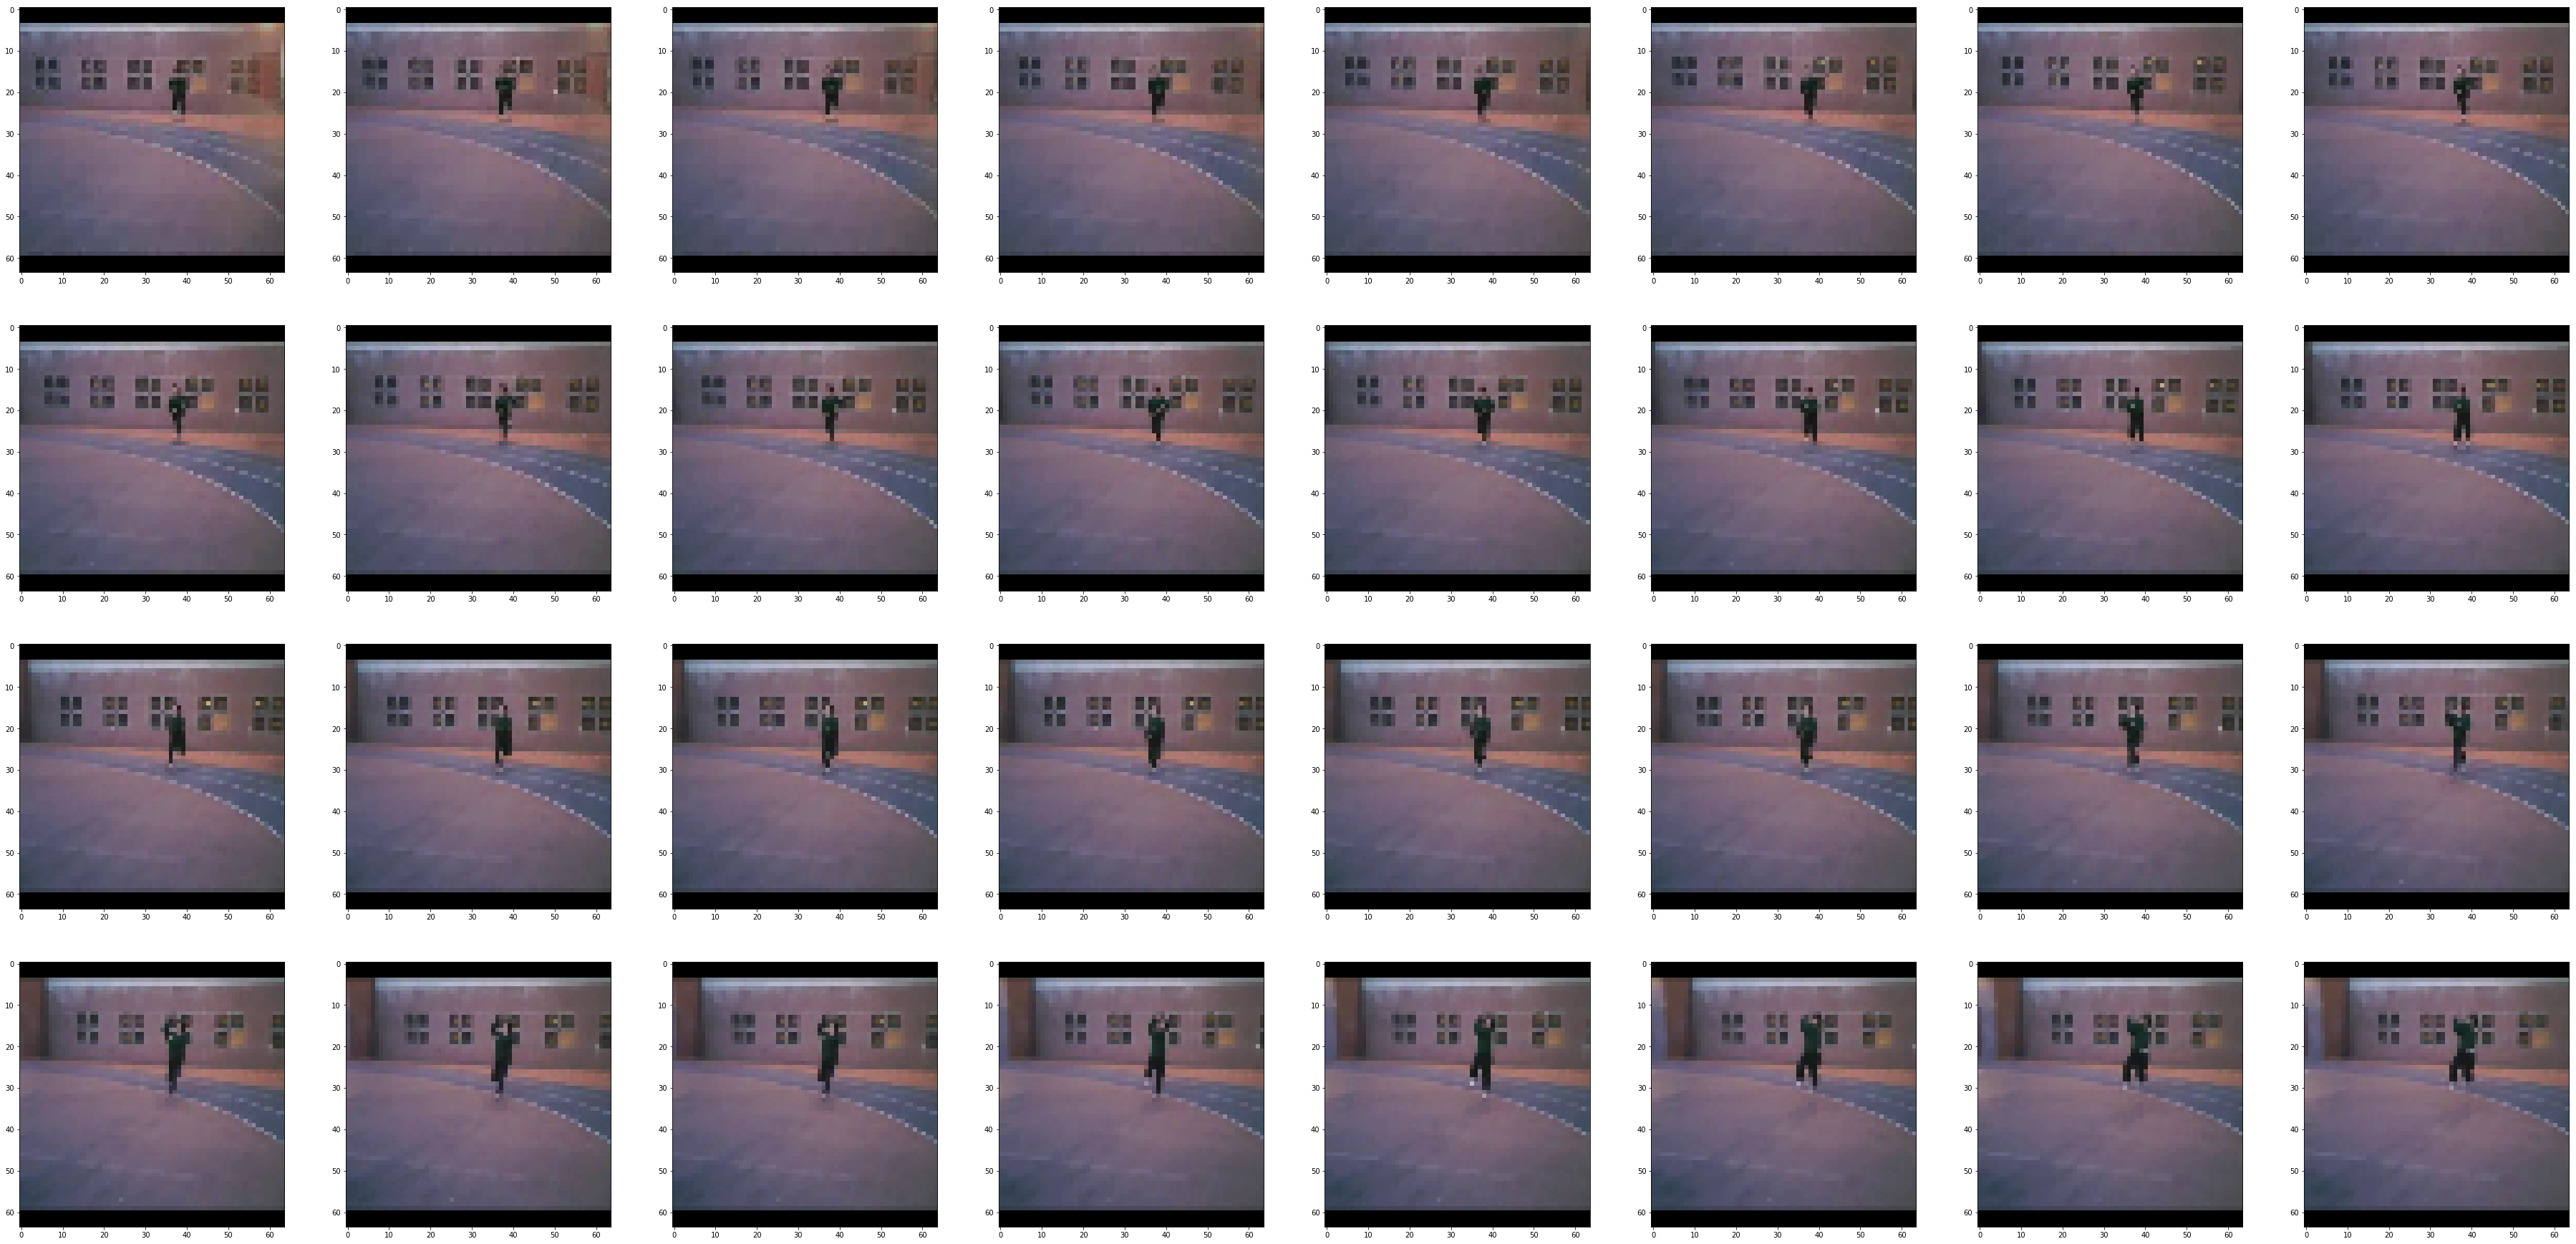

In [3]:
ext = f.frame_extractor()
x, y, _ = ext.get_frames(['/home/avikbasu/dev/DeepVideos/datasets/../../data/CricketBowling/v_CricketBowling_g04_c04.avi'])
display_images(x[0])
                


IndexError: index 21 is out of bounds for axis 0 with size 21

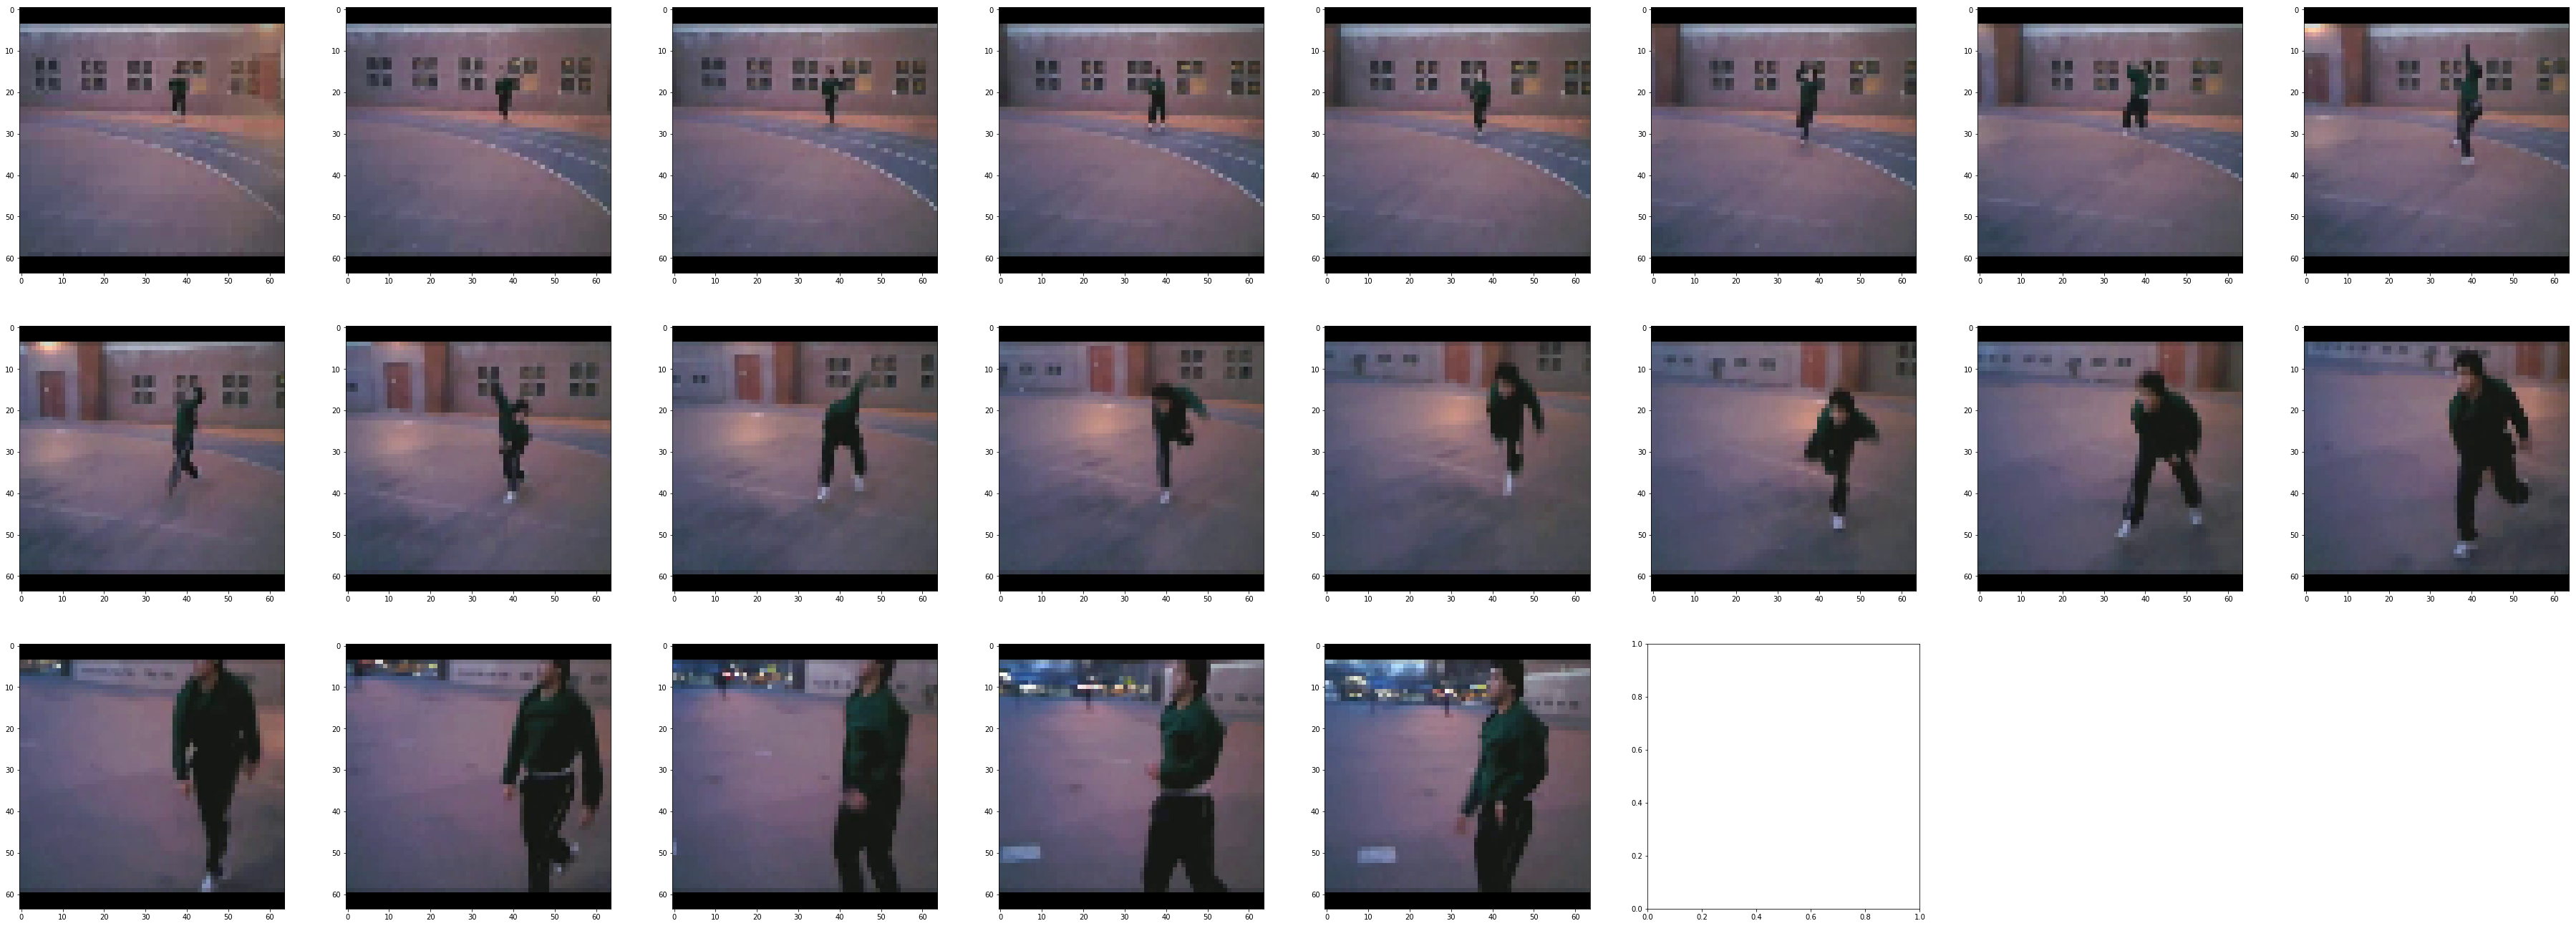

In [4]:
ext = f.frame_extractor()
o_x, o_y= ext.get_frames_with_interval_x(['/home/avikbasu/dev/DeepVideos/datasets/../../data/CricketBowling/v_CricketBowling_g04_c04.avi'],x=5)
display_images(o_x[0])

In [ ]:
ext.generate_gif_videos(o_x[0])